In [1]:
###Import standard packages###
import numpy as np
from scipy import io

###Import functions for binning data for preprocessing###
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from Area2_analysis.multi_area_funcs import smooth_spk, fit_and_predict, sub_and_predict, multi_fit_r2
import multiprocessing as mp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from Area2_analysis.lr_funcs import nans, angle_between
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
import math


2024-09-24 20:58:23.840950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## S1

### Load data

In [ ]:
foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
filename = foldername + "s1_data_raw.mat"
s1_data_raw = io.loadmat(filename)

In [ ]:
foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
filename = foldername + "s1_data_raw.mat"
s1_data_raw = io.loadmat(filename)

spike_times=s1_data_raw['spike_times']
acc = s1_data_raw['acc']
vel = s1_data_raw['vels']
pos = s1_data_raw['pos']
times = s1_data_raw['vel_times']

#original data has 0.01 s = 10 ms bins 
dt = 0.01
t_start = times[0]
t_end = times[-1]

spike_times = np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]=np.squeeze(spike_times[i])

neural_data=bin_spikes(spike_times,dt,t_start,t_end)
gauss_width = 40 #in ms
bin_width = dt*1000
smth_40 = smooth_spk(neural_data, gauss_width, bin_width)

accs_binned=bin_output(acc,times,dt,t_start,t_end)
vels_binned=bin_output(vel,times,dt,t_start,t_end)
pos_binned=bin_output(pos,times,dt,t_start,t_end)
accs_40 = smooth_spk(accs_binned, gauss_width, bin_width)
vels_40 = smooth_spk(vels_binned, gauss_width, bin_width)
pos_40 = smooth_spk(pos_binned, gauss_width, bin_width)

with open(foldername+'proc_data_s1.pickle','wb') as f:
    pickle.dump([smth_40,accs_40,vels_40, pos_40],f)

In [ ]:
neural_data.shape

In [ ]:
plt.plot(smth_40[:1000,:])

In [ ]:
# foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
# filename = foldername + "s1_data_raw.mat"
# s1_data_raw = io.loadmat(filename)

# spike_times=s1_data_raw['spike_times']
# acc = s1_data_raw['acc']
# vel = s1_data_raw['vels']
# pos = s1_data_raw['pos']
# times = s1_data_raw['vel_times']

# #original data has 0.01 s = 10 ms bins 
# dt = 0.02 #10ms bins
# t_start = times[0]
# t_end = times[-1]

# spike_times = np.squeeze(spike_times)
# for i in range(spike_times.shape[0]):
#     spike_times[i]=np.squeeze(spike_times[i])

# neural_data_20=bin_spikes(spike_times,dt,t_start,t_end)
# accs_20_binned=bin_output(acc,times,dt,t_start,t_end)
# vels_20_binned=bin_output(vel,times,dt,t_start,t_end)
# pos_20_binned=bin_output(pos,times,dt,t_start,t_end)

# with open(foldername+'proc_20_data_s1.pickle','wb') as f:
#     pickle.dump([neural_data_20,accs_20_binned,vels_20_binned,pos_20_binned],f)

### Single-lag

In [2]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_data_s1.pickle','rb') as f:
    neural_data, accs, vels, pos = pickle.load(f,encoding='latin1')
print(neural_data.shape)
print(accs.shape)
print(vels.shape)
print(pos.shape)

n_neurons = neural_data.shape[1]

n_dims = 20
if not np.isnan(neural_data).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(neural_data)
    pca = PCA(n_components=n_dims,random_state = 42)
    neural_pc = pca.fit_transform(X)
    print(neural_pc.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
s1_pca = neural_pc

(306698, 52)
(306698, 2)
(306698, 2)
(306698, 2)
(306698, 20)
PCA total var explained: 0.5621270379402465


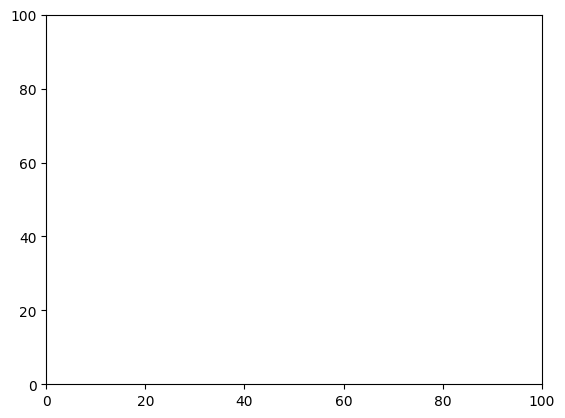

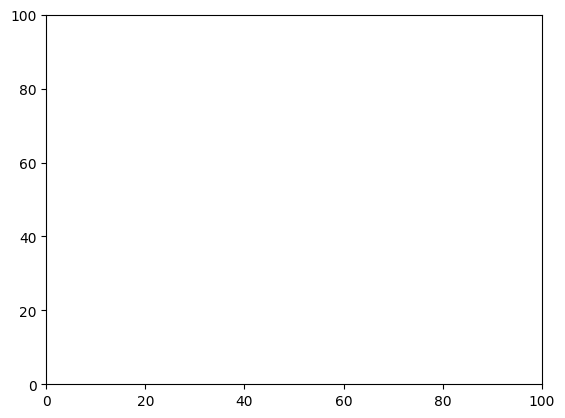

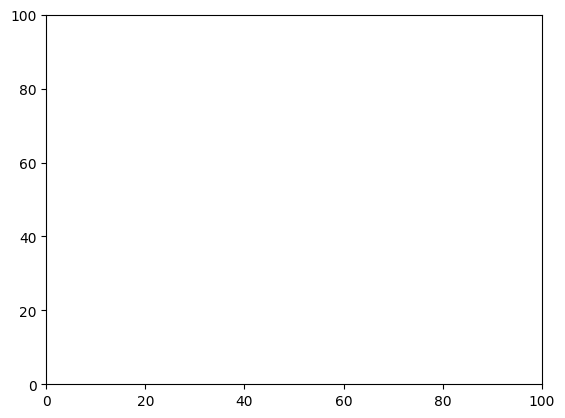

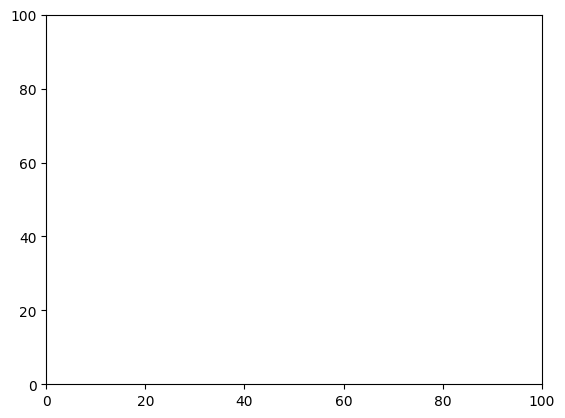

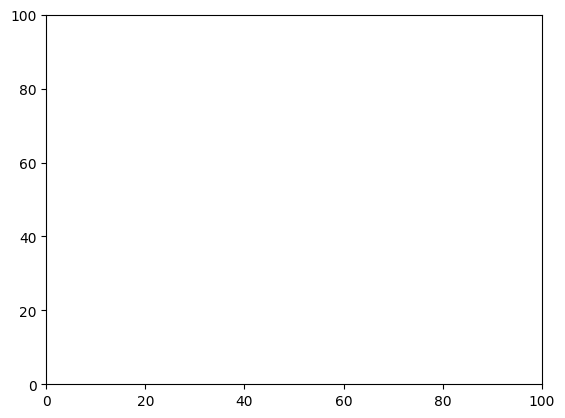

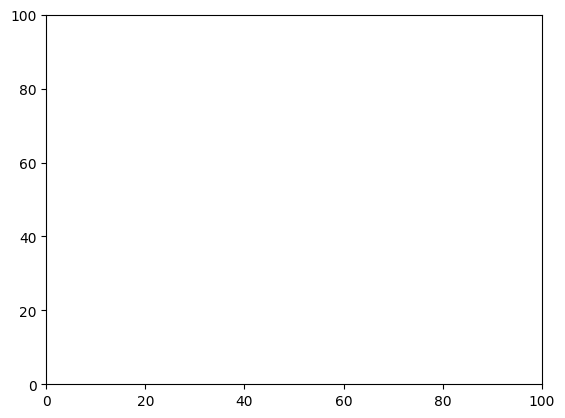

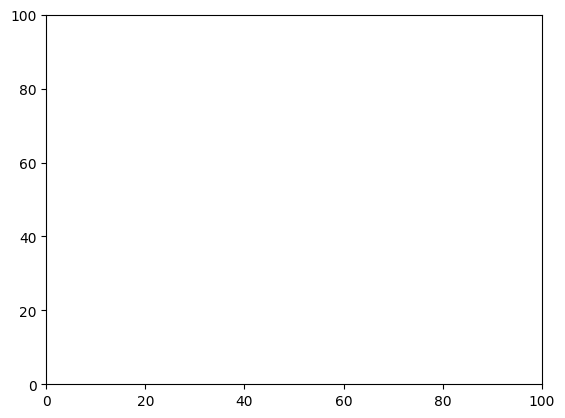

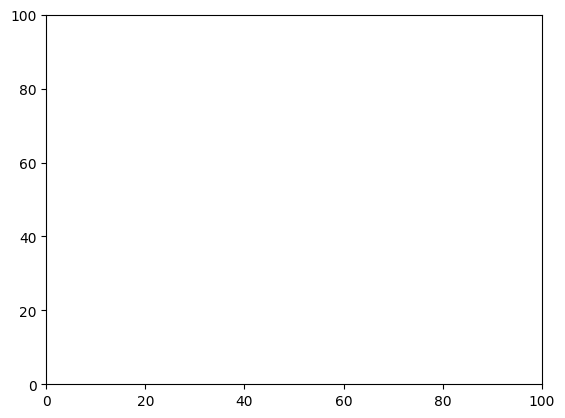

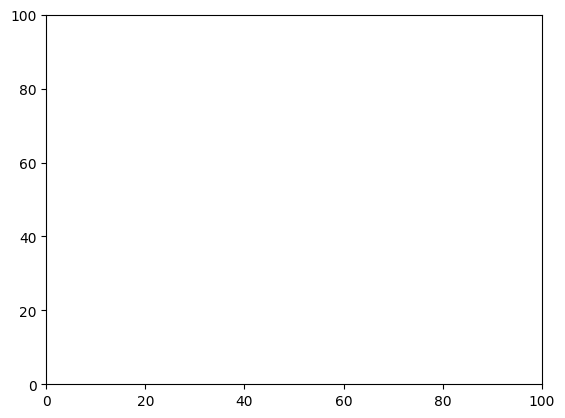

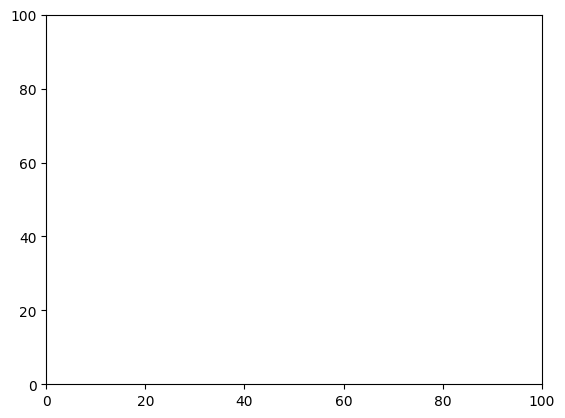

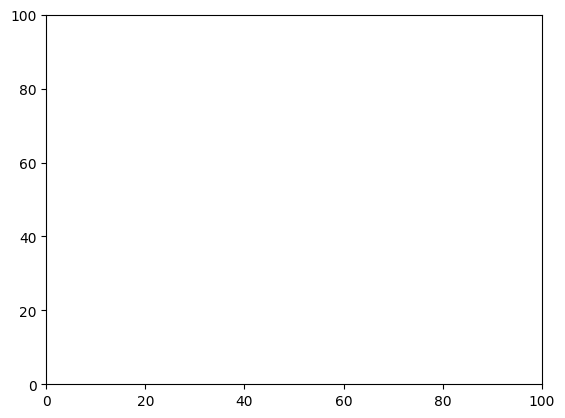

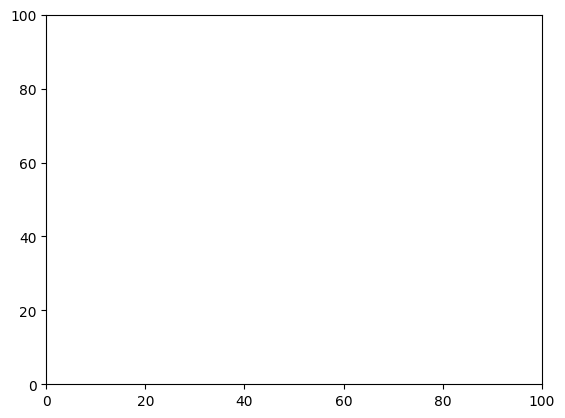

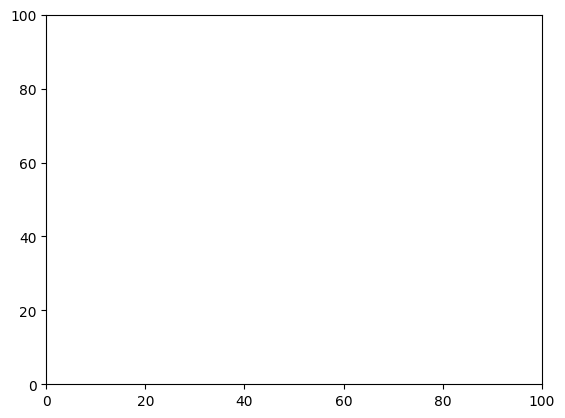

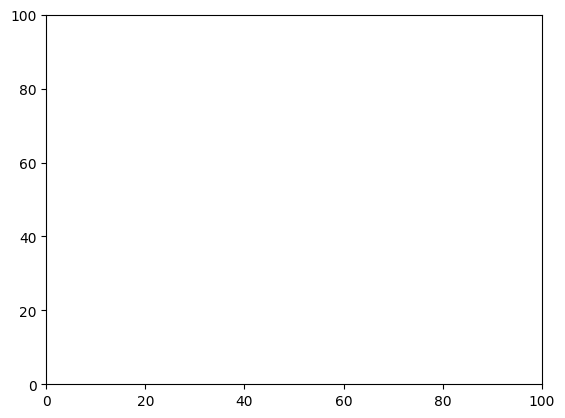

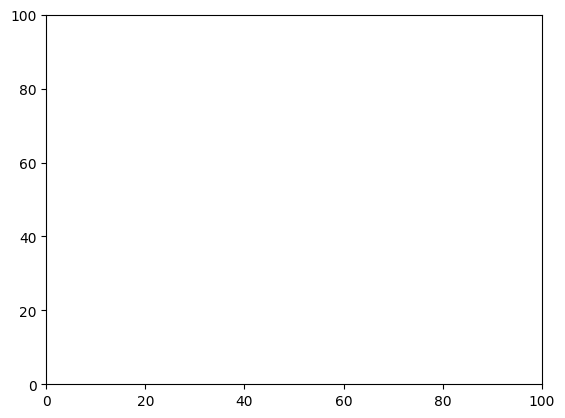

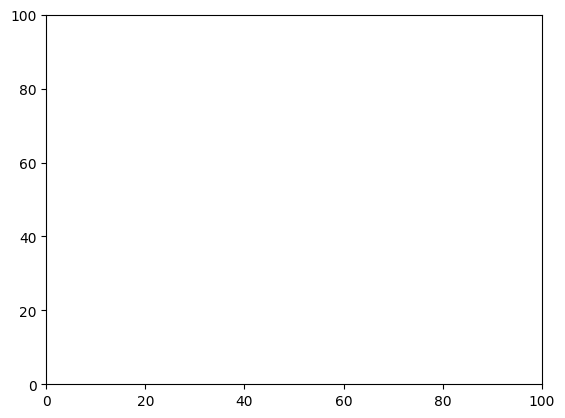

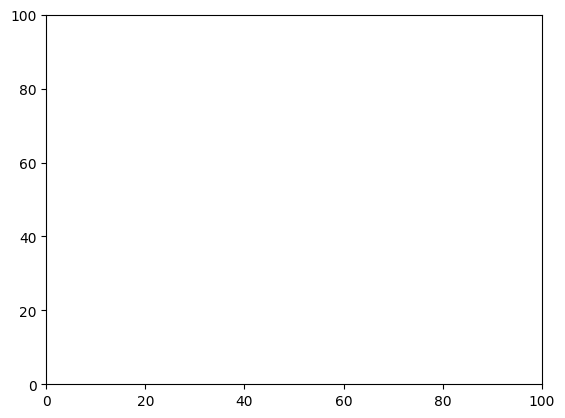

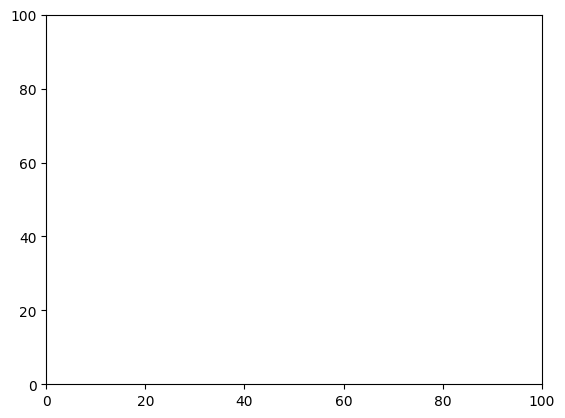

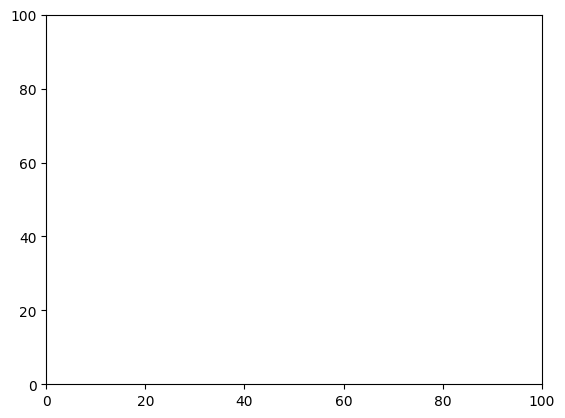

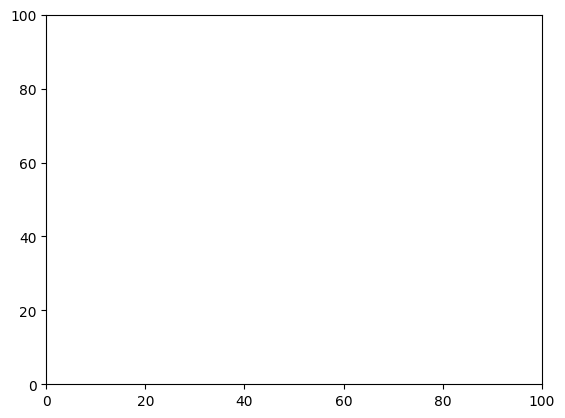

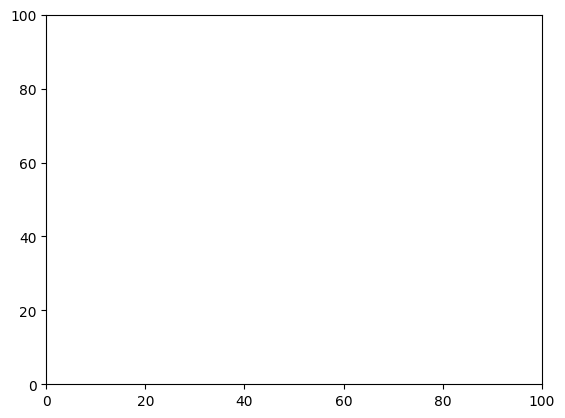

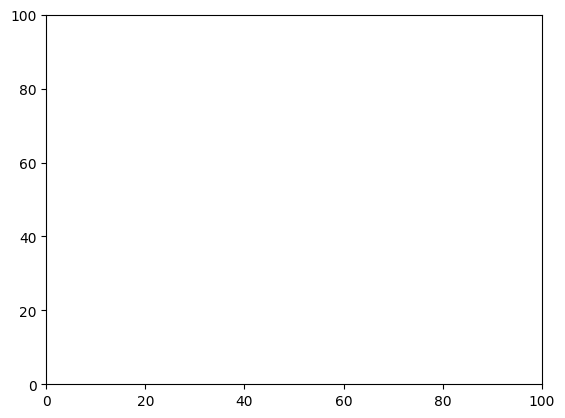

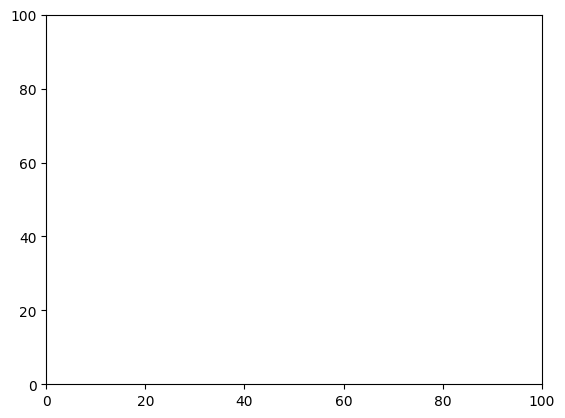

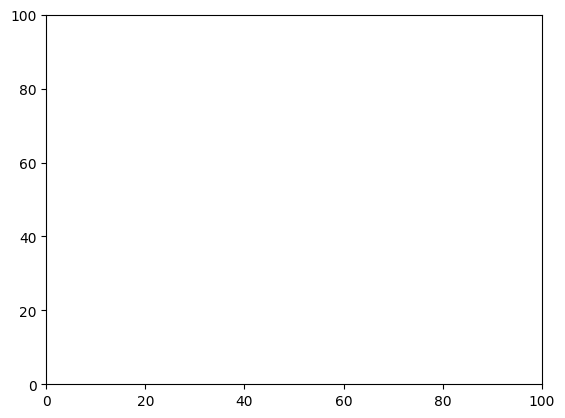

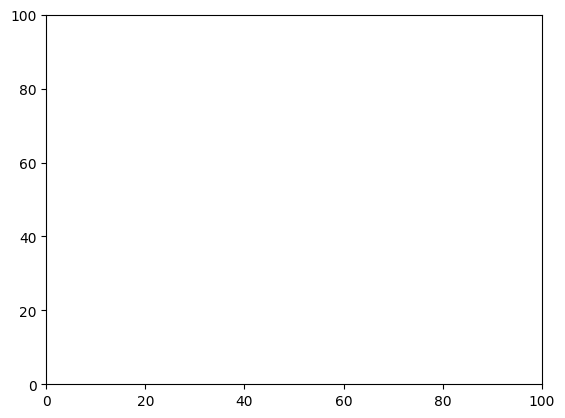

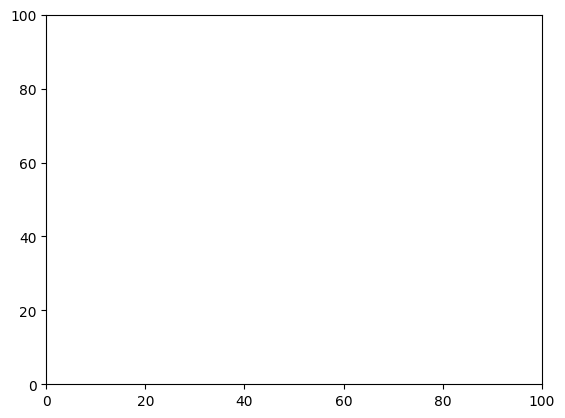

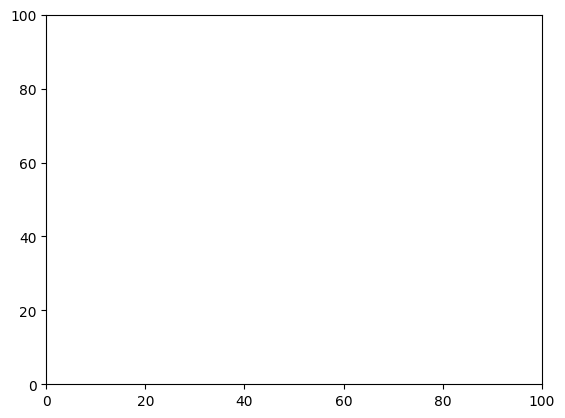

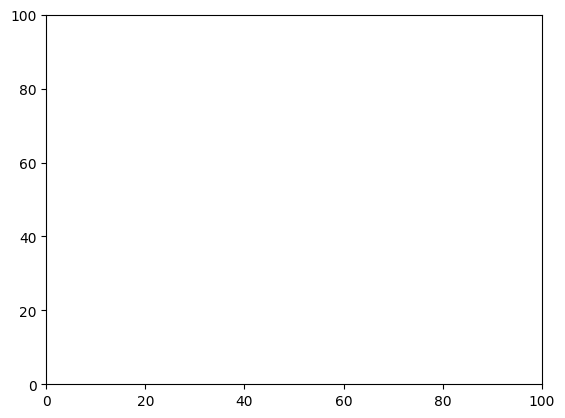

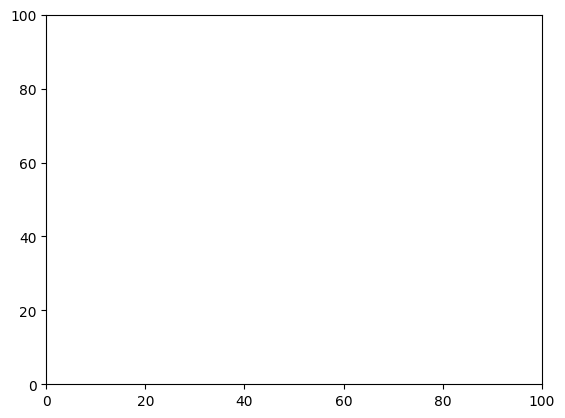

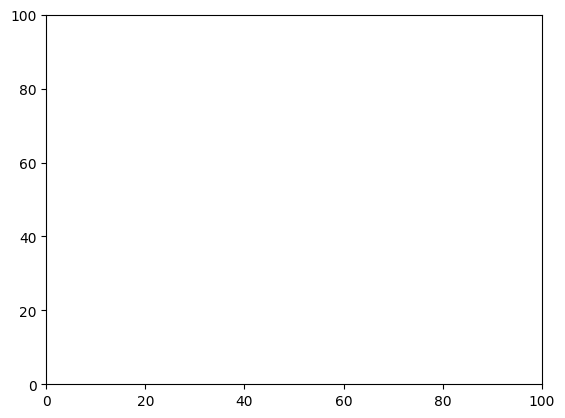

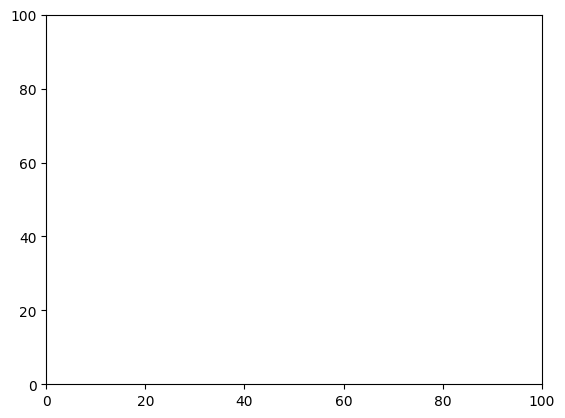

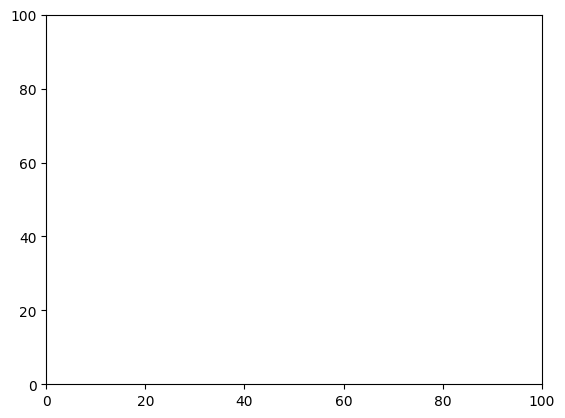

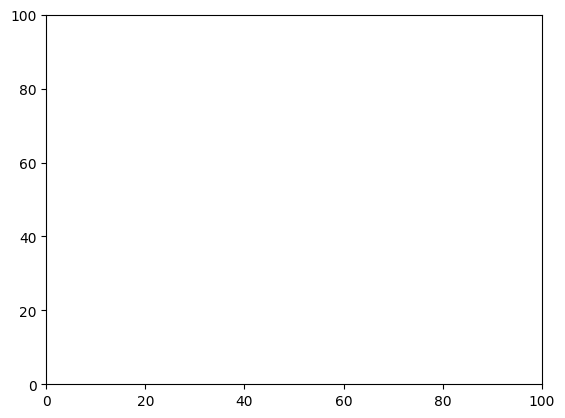

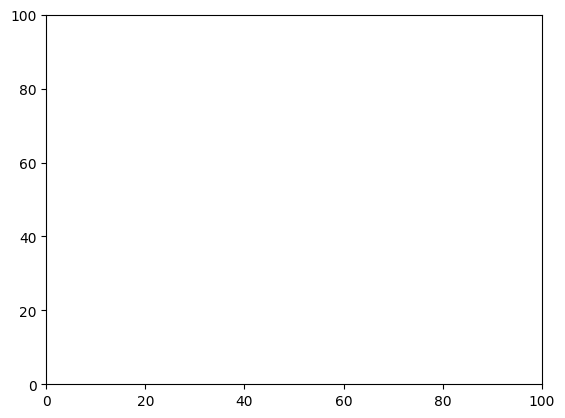

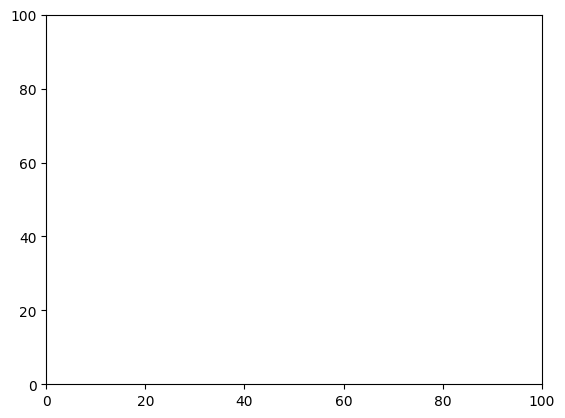

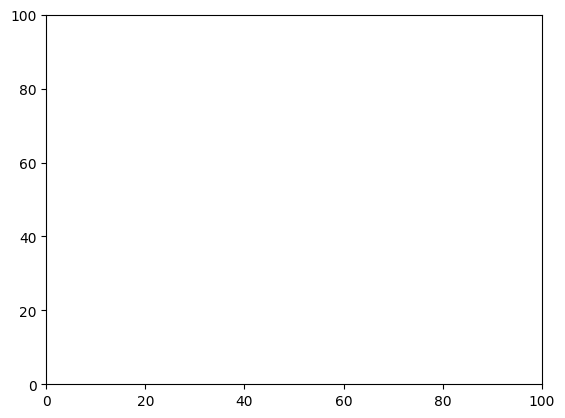

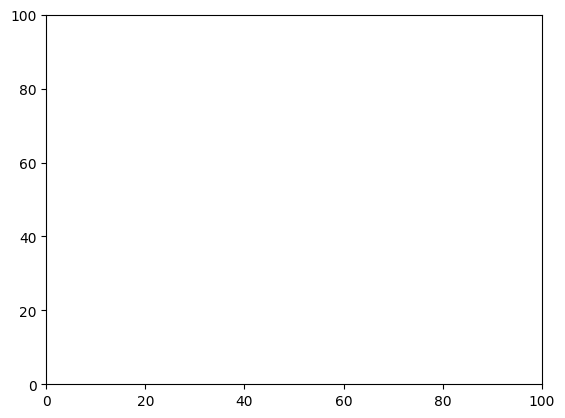

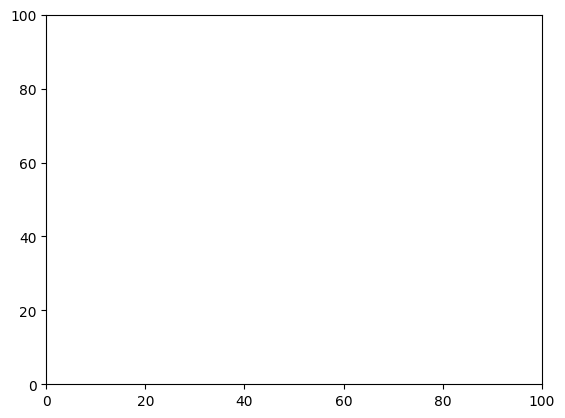

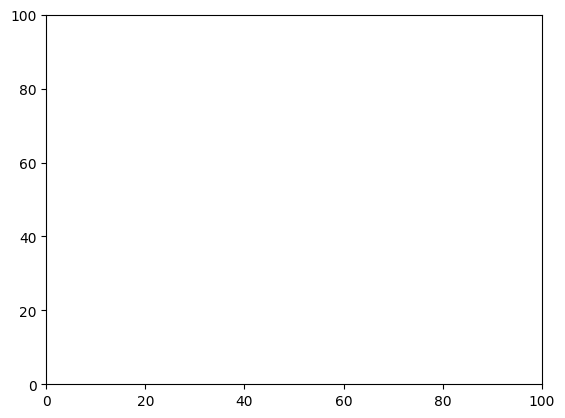

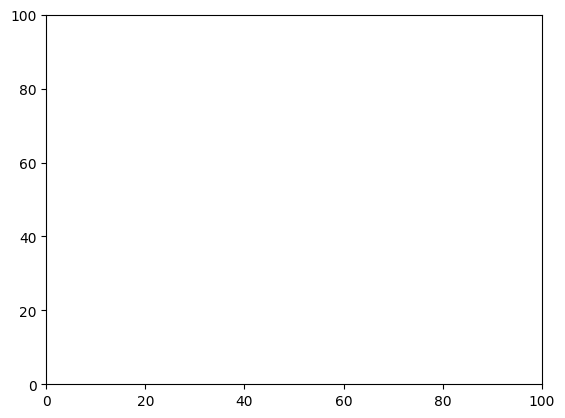

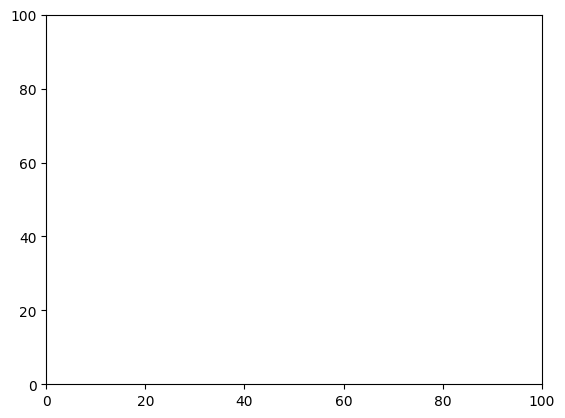

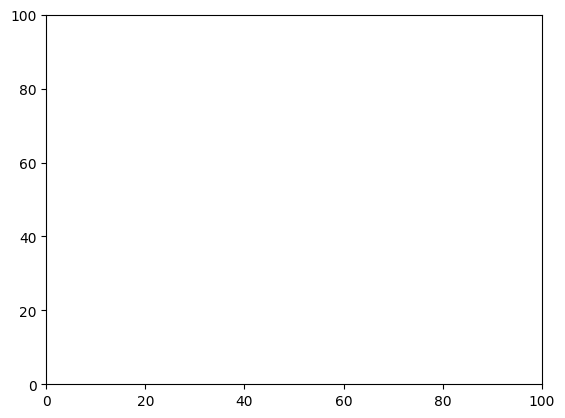

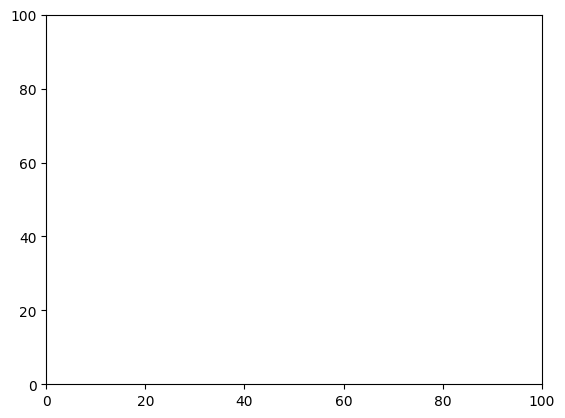

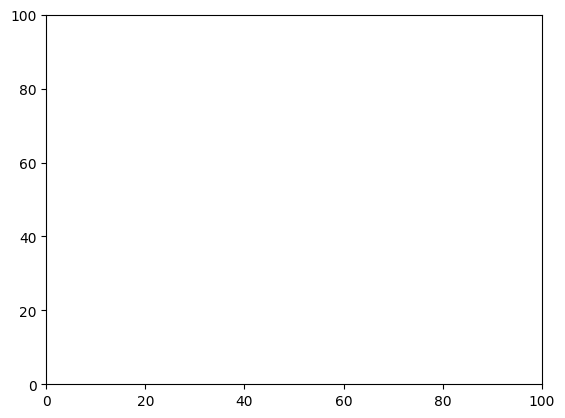

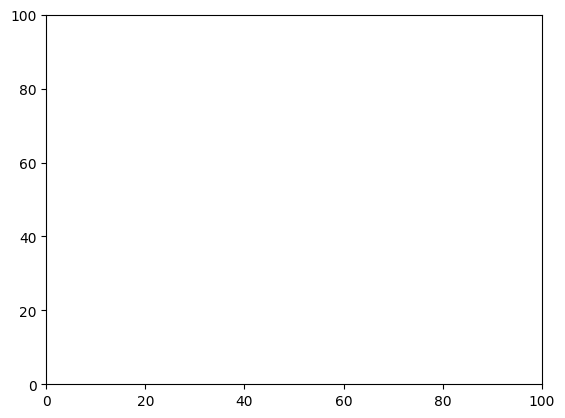

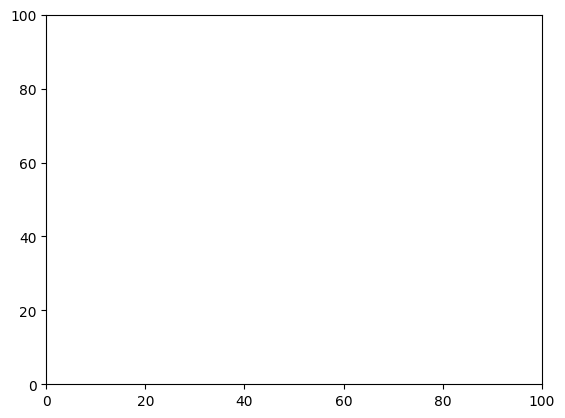

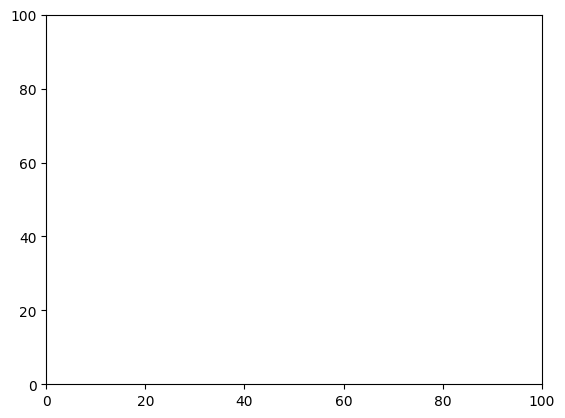

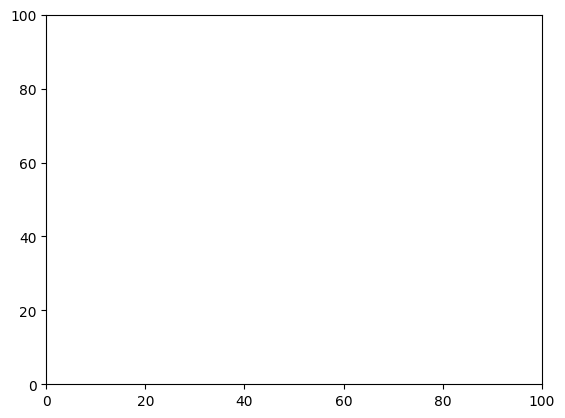

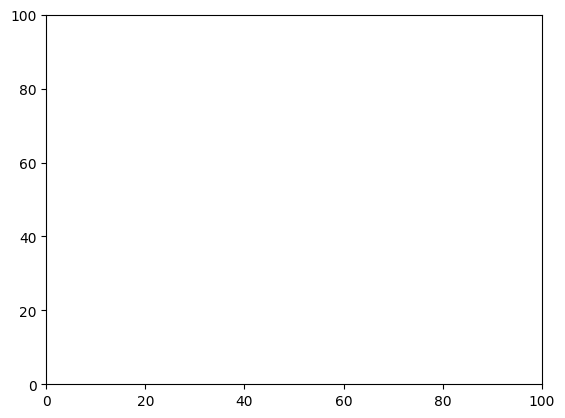

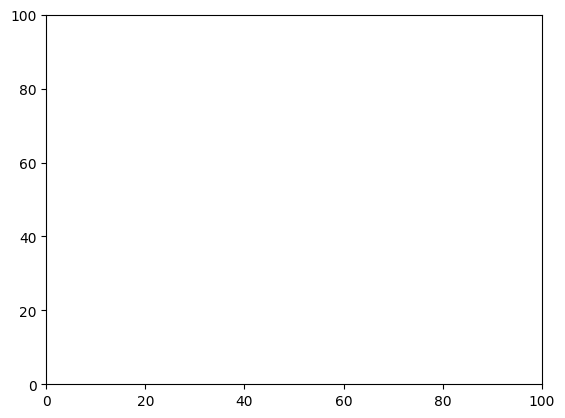

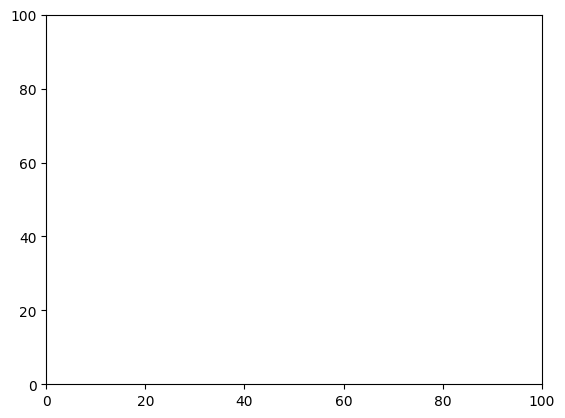

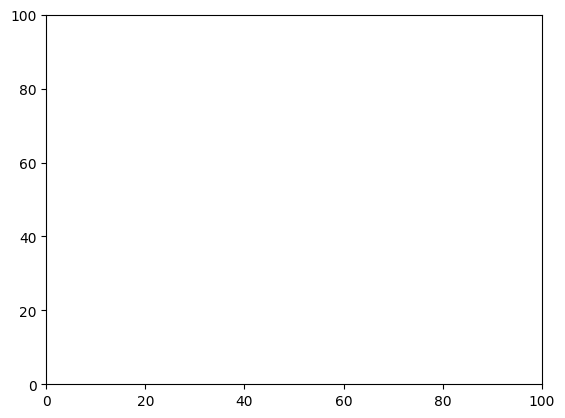

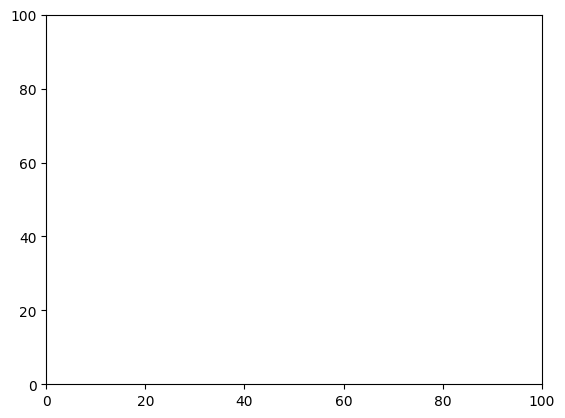

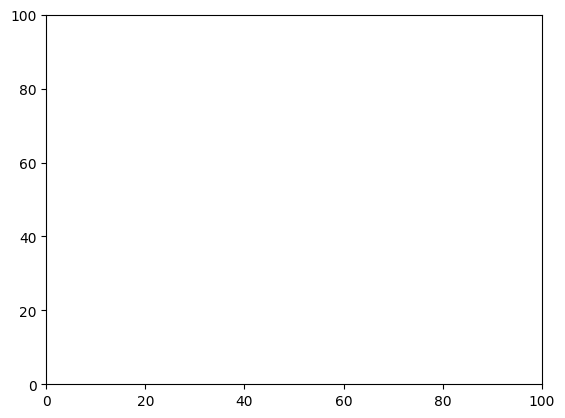

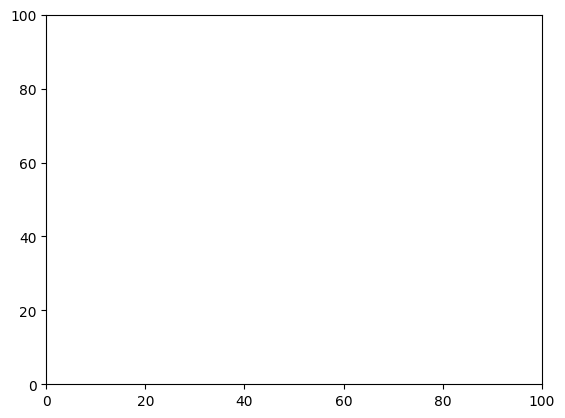

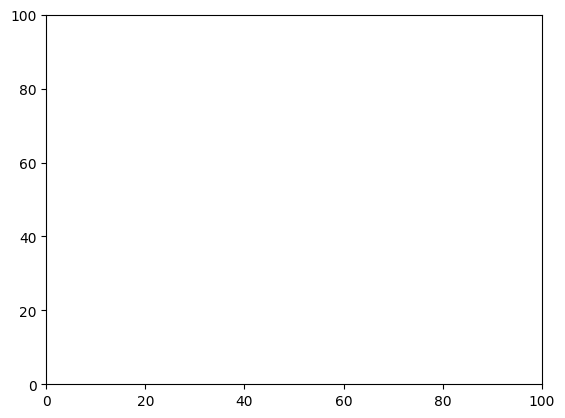

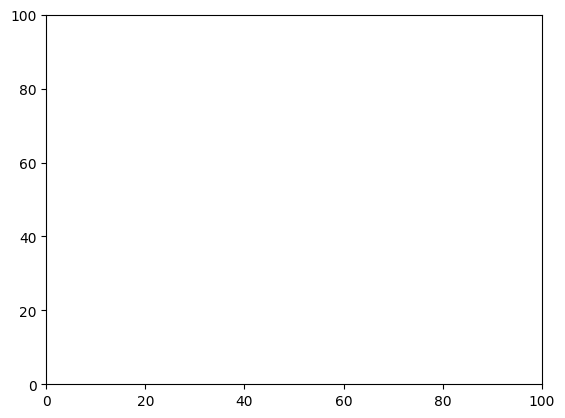

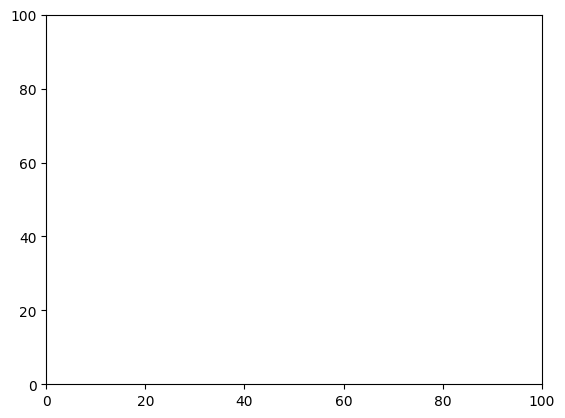

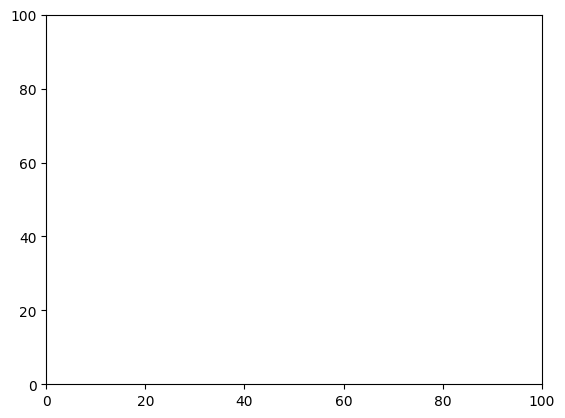

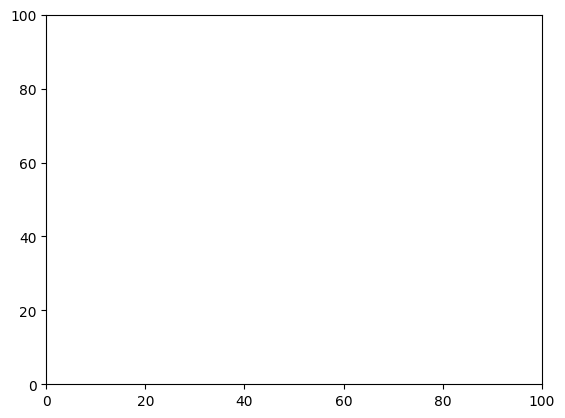

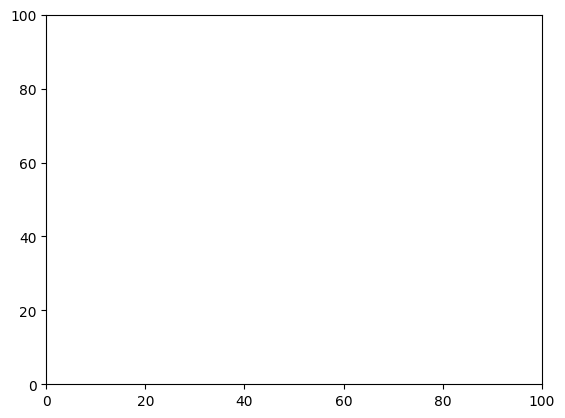

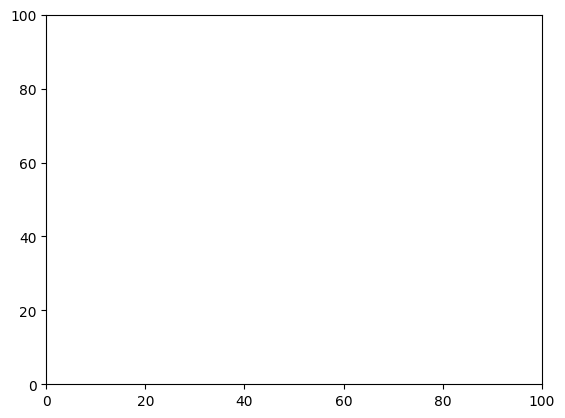

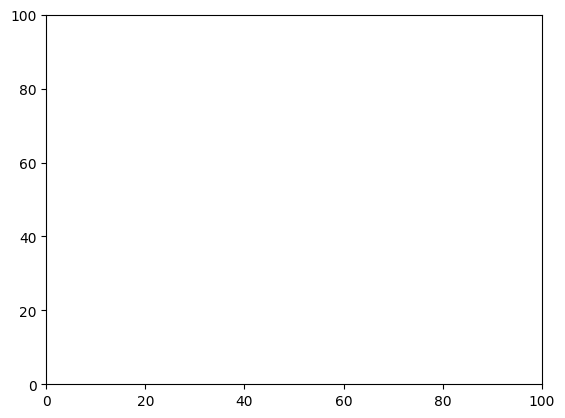

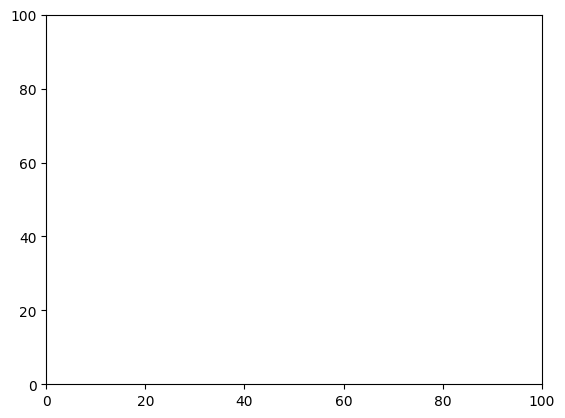

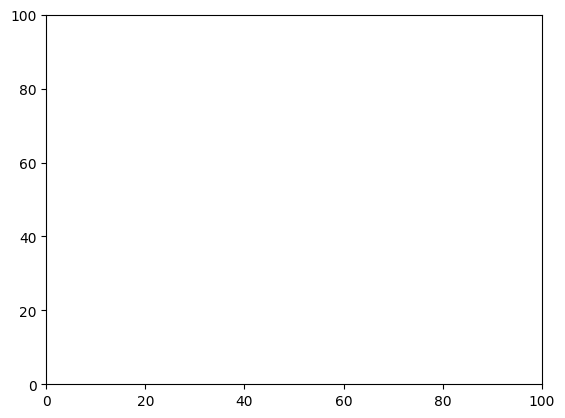

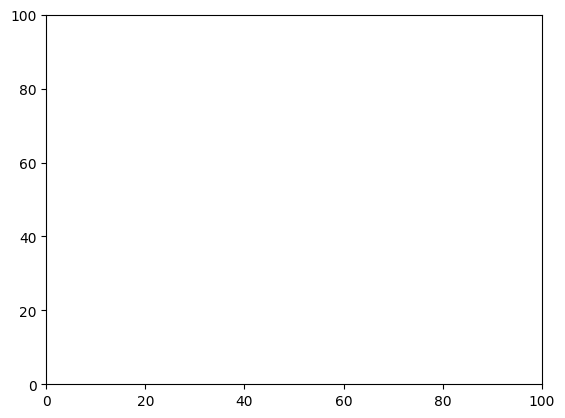

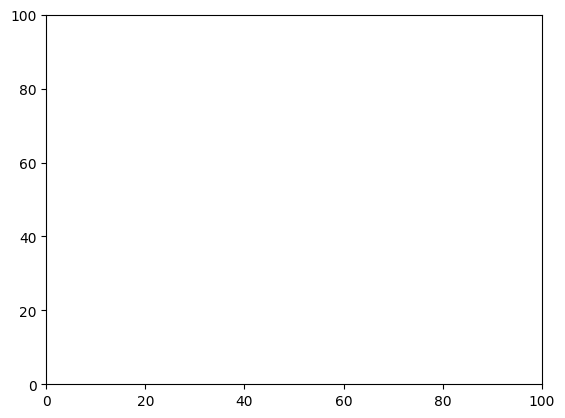

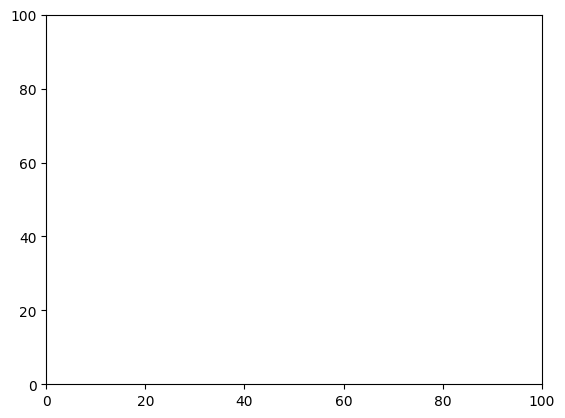

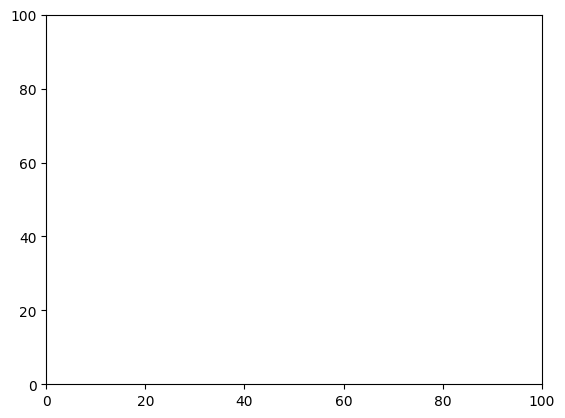

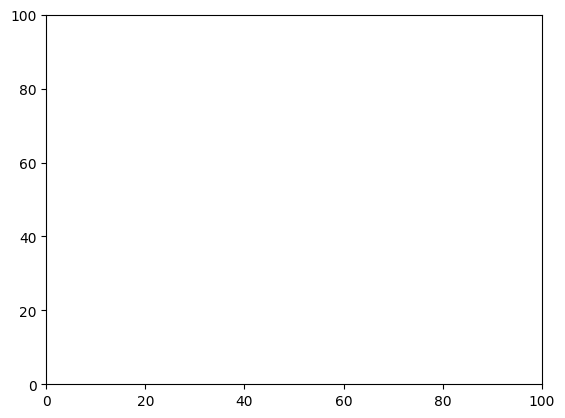

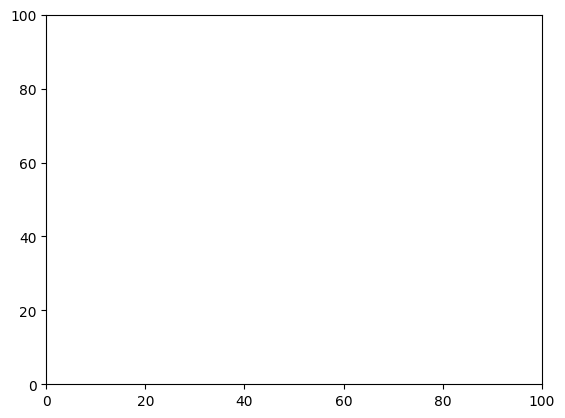

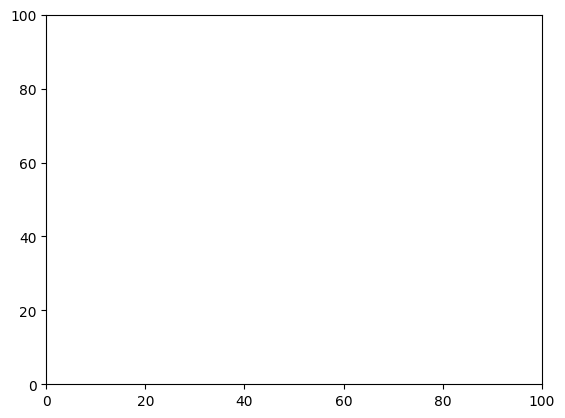

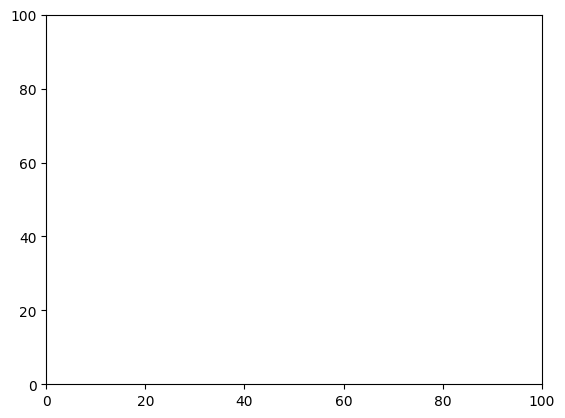

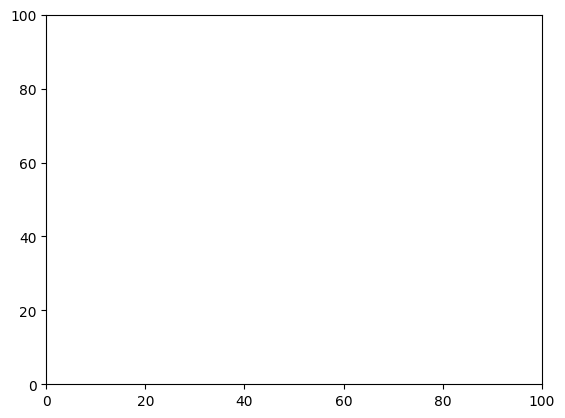

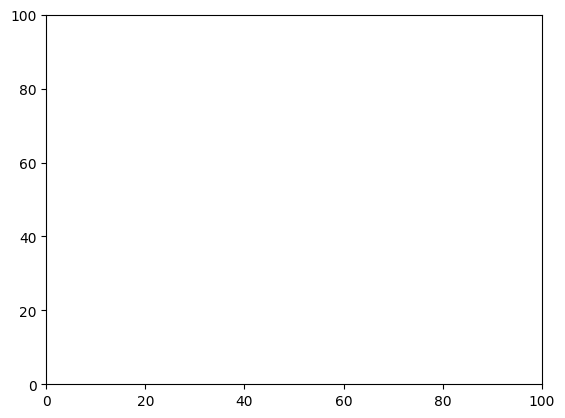

KeyboardInterrupt: 

In [4]:
plt.plot(pos[:,0],pos[:,1])

from matplotlib import pyplot as plt
 
x = []
y = []
 
for i in range(100):
    x.append(pos[i,0])
    y.append(i)
 
    # Mention x and y limits to define their range
    plt.xlim(0, 100)
    plt.ylim(0, 100)
     
    # Plotting graph
    plt.plot(x, y, color = 'green')
    plt.pause(0.01)
 
plt.show()

(1, 306698, 2)


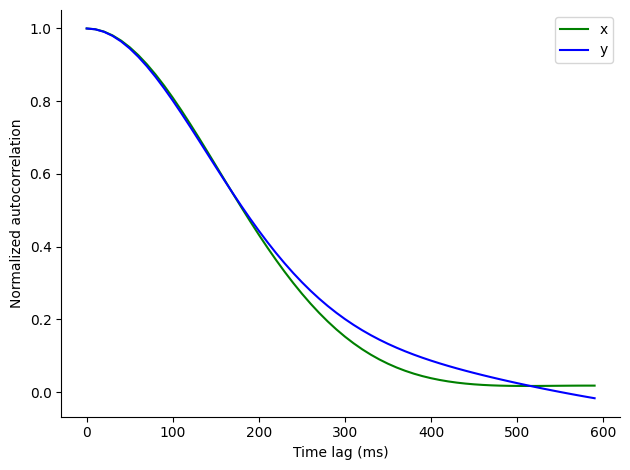

In [5]:
from Area2_analysis.lr_funcs import comp_cc
kin_array = vels.reshape(1, -1, 2)
print(kin_array.shape)
maxTimeLag = 600
binSize = 10
numBin = kin_array.shape[1]
x1 = kin_array[:,:,0]
x2 = kin_array[:,:,0]
ac_x = comp_cc(x1,x2,maxTimeLag,binSize,numBin)

x1 = kin_array[:,:,1]
x2 = kin_array[:,:,1]
ac_y = comp_cc(x1,x2,maxTimeLag,binSize,numBin)

time_axis = np.arange(0, maxTimeLag, binSize)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(time_axis,ac_x/ac_x[0],color = 'green', label = 'x')
ax.plot(time_axis,ac_y/ac_y[0],color = 'blue', label = 'y')
plt.legend()
plt.xlabel("Time lag (ms)")
plt.ylabel("Normalized autocorrelation")
plt.tight_layout()
# plt.savefig(figDir + monkey + '_autocorrelation_acc.pdf',dpi = 'figure')

In [ ]:
from sklearn.linear_model import LinearRegression
lag_axis = np.arange(-200, 200, 10)
n_runs = 25
ang_arr = nans([n_runs])
r2_arr = nans([n_runs, len(lag_axis)])
for b in range(n_runs):
    mu, sigma = 0, 1
    n_nrn = 20
    nrn_weight = np.random.normal(mu, sigma, size = (n_nrn,2)) # Random We and Wa
    nrn_weight_0 = np.random.normal(mu, sigma, size = (n_nrn,2))

    # nrn_weight = np.random.normal(mu, sigma, size = (n_nrn,1))
    # nrn_weight = np.tile(nrn_weight,(1,2)) # Random We = Wa

    # nrn_weight = np.random.normal(mu, sigma, size = (n_nrn,1))
    # nrn_weight = np.concatenate([nrn_weight, -nrn_weight], axis = 1) # Random We = -Wa

    nrn_axis = np.arange(0+20, len(neural_data)-20)
    n_bins = len(nrn_axis)
    nrn_activity = nans([n_bins, n_nrn])
    for n in range(n_nrn):
        for i in range(n_bins):
            nrn_activity[i, n] = nrn_weight[n,0]*accs[i+10, 0] + nrn_weight[n, 1]*accs[i+30, 0] + nrn_weight_0[n,0]*vels[i+10, 0] + nrn_weight_0[n, 1]*vels[i+30, 0]
            # nrn_activity[i, n] = nrn_weight[n,0]*vels[i+20, 0] 

    coefs_arr = nans([len(lag_axis), n_nrn])
    r2 = nans([len(lag_axis)])
    for i in range(len(lag_axis)):
        start, end = 40-i, len(neural_data)-i
        X = nrn_activity
        y = accs[start:end,0]
        lr =  LinearRegression().fit(X, y)
        coefs_arr[i] = lr.coef_
        r2[i] = lr.score(X, y)
    ang_arr[b] = math.degrees(angle_between(coefs_arr[np.argwhere(lag_axis==-100)[0,0],:],coefs_arr[np.argwhere(lag_axis==100)[0,0],:])) 
    r2_arr[b,:] = r2

In [ ]:
plt.plot(lag_axis, np.mean(r2_arr,axis=0))
plt.axvline(-100, color = 'k', linestyle='--')
plt.axvline(100, color = 'k', linestyle='--')
plt.xlabel("Time lag (ms)")
plt.ylabel('R2')

In [ ]:
plt.hist(ang_arr)
plt.xlabel("Angle (deg)")
plt.ylabel('Frequency')

In [5]:
from Area2_analysis.lr_funcs import nans
lag_axis = np.arange(-500, 520, 20)
x = s1_pca
dim = x.shape[1]
y = vels
r2_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef,_ = fit_and_predict(x,y,lag,bin_size=10)
    r2_array[i] = r2
    coef_array[i,:,:] = coef

0.04963146639802588
0.051418085365698765
0.0538162304332653
0.0570338131448941
0.06133004754611675
0.06702320101790905
0.07447182811994221
0.08407337789670785
0.0962327419904119
0.11133473990373477
0.12972261854064232
0.1516506314705171
0.17728503422851
0.2066733324919589
0.23974534221596838
0.2763154031535778
0.31602302016530537
0.3582956798288801
0.4022026136276571
0.4463255609447601
0.48864665479526836
0.5265213531018494
0.5568667708050955
0.5765651338848077
0.5831044848798542
0.5752833043108281
0.5537395099030917
0.520983311676425
0.4808671048085772
0.4376002245058511
0.3947671837353193
0.35472510835036875
0.3185505002051733
0.28638814131116286
0.25792026837689064
0.2327420938646015
0.21054183556926404
0.19113118309191401
0.1743906516688255
0.16020341502814323
0.1484126685052531
0.13879979034951279
0.13110558495255747
0.12502692566330556
0.12025625384536723
0.11649265943760707
0.11346044501969348
0.11093181832880439
0.10872269782559033
0.10670252082807168
0.10478007027962796


[0.04982094 0.05152099 0.0538147  0.05690594 0.06104987 0.06655752
 0.07378823 0.08313566 0.09500912 0.10980326 0.12787058 0.14949177
 0.1748521  0.20402597 0.23696806 0.2735021  0.3132825  0.3557253
 0.39988661 0.44432605 0.48699454 0.52522364 0.55590316 0.575896
 0.58267524 0.57503038 0.5535951  0.52088137 0.48074625 0.43740757
 0.3944593  0.35427381 0.31794441 0.28563665 0.25704902 0.23178418
 0.20952947 0.19008807 0.1733303  0.15913138 0.14732859 0.13770277
 0.12999203 0.12389428 0.11910143 0.11531174 0.11225139 0.10969319
 0.10745577 0.10541164 0.10347134]
-20


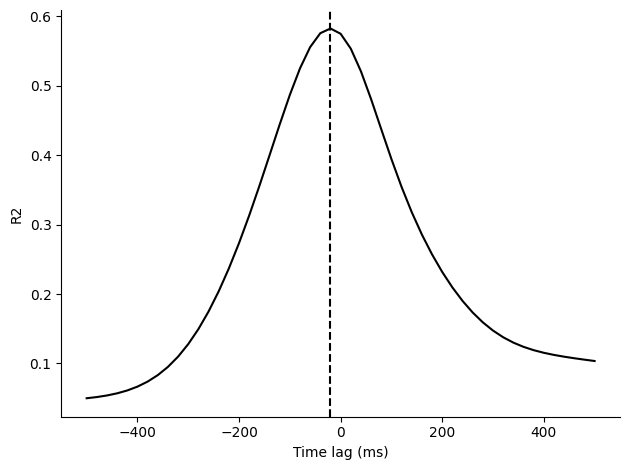

In [6]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, r2_array,color = 'k')
plt.axvline(lag_axis[np.argmax(r2_array)], color = 'k', linestyle='--')
print(r2_array)
print(lag_axis[np.argmax(r2_array)])
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
plt.show()


In [7]:
np.savez('RT_s1_single_lag', coef_array = coef_array, r2_array = r2_array, lag_axis = lag_axis) 

In [ ]:
_, _, vel_df = fit_and_predict(x,y,time_max,bin_size=10)
plt.plot(vel_df['true_x'][:1000])
plt.plot(vel_df['pred_x'][:1000])
plt.show()
plt.plot(vel_df['true_y'][:1000])
plt.plot(vel_df['pred_y'][:1000])

In [ ]:
best_decoder = coef_array[idx_max,:,:]
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef,_ = sub_and_predict(x,y,lag,10,best_decoder)
    sub_r2_array[i] = r2

In [ ]:
plt.plot(lag_axis,sub_r2_array)
plt.title('projecting out #1 t_max dim')
idx_max = np.argmax(sub_r2_array)
time_max = lag_axis[idx_max]
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
# plt.savefig(figDir + y_field +'_1.png', dpi = 'figure')
plt.show()

In [ ]:
idx_max_pos = np.argwhere(r2_array == np.max(r2_array[np.argwhere(lag_axis==0)[0,0]:]))[0,0]
idx_max_neg = np.argwhere(r2_array == np.max(r2_array[:np.argwhere(lag_axis==0)[0,0]]))[0,0]

# idx_max_pos = np.argwhere(lag_axis==40)[0,0]
# idx_max_neg = np.argwhere(lag_axis==-60)[0,0]

ang_to_max_x = nans([len(lag_axis)])
ang_to_max_y = nans([len(lag_axis)])
for i in range(0, len(coef_array)):
    ang_to_max_x[i] = math.degrees(angle_between(coef_array[i,0,:],coef_array[idx_max_neg,0,:]))
    ang_to_max_y[i] = math.degrees(angle_between(coef_array[i,1,:],coef_array[idx_max_neg,1,:]))
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.ylim([-5, 130])
plt.xlim([-310, 310])
plt.scatter(lag_axis, ang_to_max_x,label = 'x-axis',color = 'green')
plt.scatter(lag_axis, ang_to_max_y,label = 'y-axis',color = 'blue')
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('Angle (degrees)')
mean = np.mean([ang_to_max_x[idx_max_pos], ang_to_max_y[idx_max_pos]])
print(mean)
plt.vlines(lag_axis[idx_max_pos],-5, mean, color = 'k',linestyle="dashed")
plt.hlines(mean, -310, lag_axis[idx_max_pos], color = 'k',linestyle="dashed")
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(0) +'_angle.pdf', dpi = 'figure')
plt.show()

### Multi-lag

In [8]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_50_data_s1.pickle','rb') as f:
    s1_neural_data_50,s1_accs_50_binned,s1_vels_50_binned,s1_pos_50_binned=pickle.load(f,encoding='latin1')
print(s1_neural_data_50.shape)
print(s1_accs_50_binned.shape)
print(s1_vels_50_binned.shape)
print(s1_pos_50_binned.shape)

bin_width = 50

n_dims = 20
if not np.isnan(s1_neural_data_50).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(s1_neural_data_50)
    pca = PCA(n_components=n_dims,random_state = 42)
    neural_data_50_pca = pca.fit_transform(X)
    print(neural_data_50_pca.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
s1_neural_data_50_pca = neural_data_50_pca

(61339, 52)
(61339, 2)
(61339, 2)
(61339, 2)
(61339, 20)
PCA total var explained: 0.48676931827230147


In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from Area2_analysis.lr_funcs import get_sses_pred, get_sses_mean, nans, calc_proj
import numpy as np
import scipy.signal as signal
import pandas as pd

In [84]:
#Modifying my functions from Area2_analysis.funcs
def process_train_test(X,y,training_set,test_set):
    X_train = X[training_set,:]
    X_test = X[test_set,:]
    y_train = y[training_set,:]
    y_test = y[test_set,:]

    X_train_mean=np.nanmean(X_train,axis=0)
    X_train_std=np.nanstd(X_train,axis=0)   
    # X_train_std[X_train_std==0] = 1 #array with only 0 will have 0 std and cause errors
    y_train_mean=np.nanmean(y_train,axis=0)

    X_train=(X_train-X_train_mean)/X_train_std
    X_test=(X_test-X_train_mean)/X_train_std
    invalid_nrn = np.isnan(X_train).any(axis=0)
    X_train = X_train[:,~invalid_nrn]
    X_test = X_test[:,~invalid_nrn]

    y_train=y_train-y_train_mean
    y_test=y_test-y_train_mean
    return X_train,X_test,y_train,y_test


In [85]:
def multi_fit_r2_lasso(rates_array,vel_array):
    X = (rates_array - np.nanmean(rates_array,axis=0))/np.nanstd(rates_array,axis=0)
    Y = vel_array - np.nanmean(vel_array,axis=0)
    lr_all = GridSearchCV(Lasso(), {'alpha': np.logspace(-3, 3, 7)})
    lr_all.fit(X, Y)
    print(lr_all.best_score_)
    coef = lr_all.best_estimator_.coef_
    n_timepoints = rates_array.shape[0]
    kf = KFold(n_splits=5,shuffle=False)   
    true_concat = nans([n_timepoints,2])
    pred_concat = nans([n_timepoints,2])
    save_idx = 0
    for training_set, test_set in kf.split(range(0,n_timepoints)):
        X_train, X_test, y_train, y_test = process_train_test(rates_array,vel_array,training_set,test_set)
        lr = GridSearchCV(Lasso(), {'alpha': np.logspace(-3, 3, 7)}) 
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)
        n = y_test_predicted.shape[0]
        true_concat[save_idx:save_idx+n,:] = y_test
        pred_concat[save_idx:save_idx+n,:] = y_test_predicted
        save_idx += n
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    r2 =1-np.sum(sses)/np.sum(sses_mean)     
    return r2, coef

Predicting with 0 to 0 ms neural data
(61339, 20)
0.434795379738177
R2: 0.43404705520284226
Predicting with 0 to 50 ms neural data
(61339, 40)
0.5070846606492418
R2: 0.5066832896487619
Predicting with 0 to 100 ms neural data
(61339, 60)
0.5286820147425859
R2: 0.5283569461220214
Predicting with 0 to 150 ms neural data
(61339, 80)
0.5367431076866561
R2: 0.5364178544575683
Predicting with 0 to 200 ms neural data
(61339, 100)
0.5407057969656758
R2: 0.5404169756291621
Predicting with 0 to 250 ms neural data
(61339, 120)
0.5432286489746314
R2: 0.5429371120039747
Predicting with 0 to 300 ms neural data
(61339, 140)
0.5449595733485191
R2: 0.5446685510989768
Predicting with 0 to 350 ms neural data
(61339, 160)
0.546231113011649
R2: 0.5459057723281511
Predicting with 0 to 400 ms neural data
(61339, 180)
0.5472238758077953
R2: 0.5468495556323675
Predicting with 0 to 450 ms neural data
(61339, 200)
0.5481540465902621
R2: 0.5477373764184195
Predicting with 0 to 500 ms neural data
(61339, 220)
0.548

/var/folders/c_/3p5f6szx247fkf6ftdgp147w0000gn/T/ipykernel_63652/2630934351.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


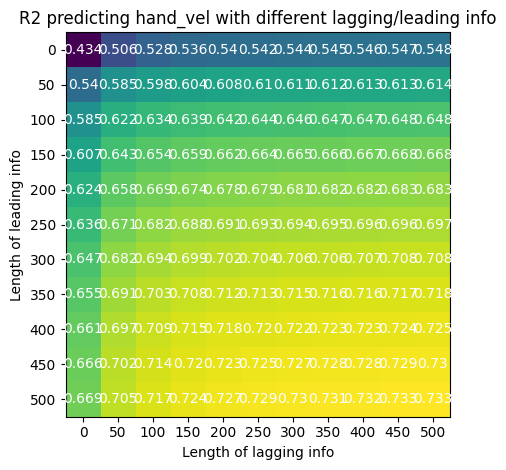

In [90]:
x_field = 'PCA'
y_field = 'hand_vel'

if x_field == 'neurons':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/neurons/S1/"
    x = s1_neural_data_50
if x_field == 'PCA':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/PCA/S1/"
    x = s1_neural_data_50_pca
if y_field == 'hand_vel':
    y = s1_vels_50_binned
if y_field == 'hand_acc':
    y = s1_accs_50_binned

t_before_range = range(0,501,50)
t_after_range = range(0,501,50)
s1_multi_R2s = nans([len(t_before_range),len(t_after_range)])
s1_multi_coefs = []
j,k = 0,0
for t_before in t_after_range:
    for t_after in t_after_range:
        print('Predicting with',-t_before, 'to', t_after,'ms neural data')
        bins_before= int(t_before/bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(t_after/bin_width) #How many bins of neural data after the output are used for decoding
        X_cov = get_spikes_with_history(x,bins_before,bins_after,bins_current)
        X_flat = X_cov.reshape(X_cov.shape[0],(X_cov.shape[1]*X_cov.shape[2]))
        print(X_flat.shape)
        X_chopped = X_flat[~np.isnan(X_flat).any(axis = 1)]
        y_chopped = y[0+bins_before:y.shape[0]-bins_after,:]
        r2, coef = multi_fit_r2_lasso(X_chopped,y_chopped)
        s1_multi_R2s[j,k] = r2
        s1_multi_coefs.append(coef)
        print('R2:',s1_multi_R2s[j,k])
        k+=1
    j+=1
    k=0

fig, ax = plt.subplots()
im = ax.imshow(s1_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title('R2 predicting ' + y_field +' with different lagging/leading info')
fig.tight_layout()
for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(s1_multi_R2s[i, j]*1000)/1000),
                        ha="center", va="center", color="w")

plt.tight_layout()
plt.show()
# plt.savefig(figDir + y_field + '_multi_lag.png', dpi = 'figure')
# plt.close()

In [123]:
coef_X[1,:]

array([-3.63206463e-01,  3.01601421e-01, -8.06891571e-02,  1.56190524e-01,
       -3.33242950e-02,  9.55725082e-02, -1.74593809e-01, -1.54576984e-01,
        1.06765205e-02,  0.00000000e+00,  0.00000000e+00, -6.37499102e-03,
        6.09654185e-03, -4.59976818e-02,  4.72993641e-02, -3.10528200e-02,
        4.42726291e-03, -0.00000000e+00, -1.59917689e-02, -1.95049645e-02,
       -2.57532966e-01,  2.67297740e-01, -1.27819670e-01,  1.56960549e-01,
       -8.85734451e-03,  1.15063652e-01, -1.38171343e-01, -1.28720901e-01,
        1.18843798e-02,  9.51874973e-03,  0.00000000e+00, -5.44945878e-03,
        0.00000000e+00, -5.93602531e-02,  4.90251223e-02, -1.02044163e-02,
        1.39102703e-03, -1.22368006e-02, -9.90647335e-03, -3.26453009e-02,
       -2.68599024e-01,  2.82873718e-01, -1.36408217e-01,  1.60916018e-01,
       -0.00000000e+00,  1.03388101e-01, -1.17427800e-01, -9.72979259e-02,
        4.79961688e-03,  1.82469126e-02,  2.61351853e-02, -1.37513081e-02,
        5.66589380e-03, -

Text(0.5, 0, 'Time lag (ms)')

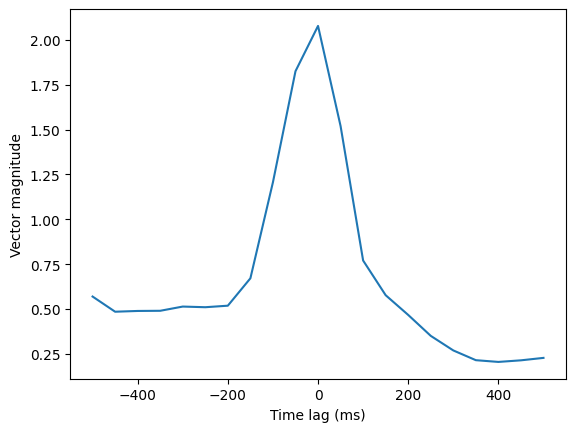

In [120]:
coef_X = s1_multi_coefs[120] #which entry's weights to use

t_label = np.arange(-500,501,50)
n_weights = len(t_label)
coef_X_reshaped = coef_X[1,:].reshape(n_weights,dim)
# angDist_array = nans([n_weights,n_weights])
# for i in range(n_weights):
#     for j in range(n_weights):
#         angDist_array[i,j] = math.degrees(angle_between(coef_X_reshaped[i,:],coef_X_reshaped[j,:]))
# fig, ax = plt.subplots(figsize=(6, 6))
# im = ax.imshow(angDist_array)
# ax.set_xlabel('Bin time (ms)')
# ax.set_ylabel('Bin time (ms)')

# ax.set_xticks(np.arange(len(t_label)))
# ax.set_yticks(np.arange(len(t_label)))
# ax.set_xticklabels(labels=t_label)
# ax.set_yticklabels(labels=t_label)

# ax.set_title("Angle between weight vectors at time points")
# fig.tight_layout()

# for i in range(len(t_label)):
#     for j in range(len(t_label)):
#         text = ax.text(j, i, str(int(angDist_array[i, j])),
#                         ha="center", va="center", color="w")
# plt.tight_layout()
# plt.show()
# # plt.savefig(figDir + y_field + '_multi_lag_angles.png', dpi = 'figure')
# # plt.close()

weights = [np.linalg.norm(i) for i in coef_X_reshaped]
plt.plot(range(-500,501,50),weights)
plt.ylabel('Vector magnitude')
plt.xlabel('Time lag (ms)')

In [112]:
import pickle
d = {'s1_multi_R2s': s1_multi_R2s, 's1_multi_coefs': s1_multi_coefs}
pickle.dump(d, open('RT_s1_multi_lag_lasso.pickle', 'wb'))

d = pickle.load(open('RT_s1_multi_lag_lasso.pickle', 'rb'))
s1_multi_coefs = d['s1_multi_coefs']

## M1

### Load data

In [ ]:
# foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
# filename = foldername + "m1_data_raw.mat"
# m1_data_raw = io.loadmat(filename)

# spike_times=m1_data_raw['spike_times'][:70,:] #only first 70 are M1 neurons
# acc = m1_data_raw['acc']
# vel = m1_data_raw['vels']
# times = m1_data_raw['vel_times']

# #original data has 0.001 s = 1 ms bins 
# dt = 0.01
# t_start = times[0]
# t_end = times[-1]

# spike_times = np.squeeze(spike_times)
# for i in range(spike_times.shape[0]):
#     spike_times[i]=np.squeeze(spike_times[i])

# neural_data=bin_spikes(spike_times,dt,t_start,t_end)
# gauss_width = 40 #in ms
# bin_width = dt*1000
# smth_40 = smooth_spk(neural_data, gauss_width, bin_width)
# smth_20 = smooth_spk(neural_data, 20, bin_width)

# accs_binned=bin_output(acc,times,dt,t_start,t_end)
# vels_binned=bin_output(vel,times,dt,t_start,t_end)

# with open(foldername+'proc_data_m1.pickle','wb') as f:
#     pickle.dump([smth_40, smth_20,accs_binned,vels_binned],f)

In [ ]:
# foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
# filename = foldername + "m1_data_raw.mat"
# m1_data_raw = io.loadmat(filename)

# spike_times=m1_data_raw['spike_times'][:70,:]
# acc = m1_data_raw['acc']
# vel = m1_data_raw['vels']
# times = m1_data_raw['vel_times']

# #original data has 0.001 s = 1 ms bins 
# dt = 0.05 #50ms bins
# t_start = times[0]
# t_end = times[-1]

# spike_times = np.squeeze(spike_times)
# for i in range(spike_times.shape[0]):
#     spike_times[i]=np.squeeze(spike_times[i])

# neural_data_50=bin_spikes(spike_times,dt,t_start,t_end)
# accs_50_binned=bin_output(acc,times,dt,t_start,t_end)
# vels_50_binned=bin_output(vel,times,dt,t_start,t_end)

# with open(foldername+'proc_50_data_m1.pickle','wb') as f:
#     pickle.dump([neural_data_50,accs_50_binned,vels_50_binned],f)

### Single-lag

In [93]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_data_m1.pickle','rb') as f:
    m1_smth_40,m1_smth_20,m1_accs_binned, m1_vels_binned=pickle.load(f,encoding='latin1')
print(m1_smth_40.shape)
print(m1_smth_20.shape)
print(m1_accs_binned.shape)
print(m1_vels_binned.shape)

n_neurons = m1_smth_20.shape[1]

n_dims = 20
if not np.isnan(m1_smth_40).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(m1_smth_40)
    pca = PCA(n_components=n_dims,random_state = 42)
    smth_40_pca = pca.fit_transform(X)
    print(smth_40_pca.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
m1_40_pca = smth_40_pca

(126499, 70)
(126499, 70)
(126499, 2)
(126499, 2)
(126499, 20)
PCA total var explained: 0.5520019353069091


In [95]:
lag_axis = np.arange(-500, 520, 20)
x = m1_40_pca
dim = x.shape[1]
y = m1_vels_binned
r2_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef,_ = fit_and_predict(x,y,lag,bin_size=10)
    r2_array[i] = r2
    coef_array[i,:,:] = coef

0.08478887999550132
0.09531901043771521
0.10893904893503033
0.12596039884471644
0.14653270289957895
0.17062997408150152
0.19805866157967347
0.22849147035153833
0.2614937732330697
0.29654164603230027
0.3330240911795047
0.3702328208664122
0.40733068424208396
0.4433198331485215
0.4770152613730051
0.5070492698654168
0.5319393359670638
0.5502361465208999
0.5607418898254954
0.5627718335958154
0.556358401142478
0.5423291678045786
0.5222179183497455
0.49801768234349747
0.4718370653674858
0.4455244126627617
0.4203680748295602
0.39695599592388103
0.3752662933040624
0.35491149146199935
0.3353963798084403
0.316307516146292
0.2974190728126522
0.27870182285061257
0.2602934451478428
0.2424234444860592
0.22533841875044444
0.20924860198505607
0.1942895906558714
0.18050816881976656
0.16787040637381231
0.15629651623863142
0.14570158812080664
0.13603194703626573
0.12726558302096666
0.11940183881781748
0.11243129005371377
0.10631649582162964
0.10098528743627382
0.09633123587896684
0.09222509963208143


[0.08560126 0.0960197  0.10953872 0.12646655 0.14695159 0.17097156
 0.19834305 0.22875437 0.2617895  0.29694034 0.33360508 0.37107429
 0.40849468 0.44484034 0.4788876  0.50922659 0.53434608 0.55278279
 0.56335267 0.5653963  0.5589745  0.54492937 0.52477781 0.50047106
 0.47406539 0.44738329 0.4217321  0.39775523 0.37550308 0.35464818
 0.33472903 0.31533719 0.29623247 0.27736385 0.25884515 0.2408856
 0.22371844 0.2075458  0.19250261 0.17863802 0.16592363 0.15428873
 0.14365452 0.13397396 0.12523047 0.11742626 0.11055526 0.10457579
 0.09940913 0.09493752 0.09101991]
-120


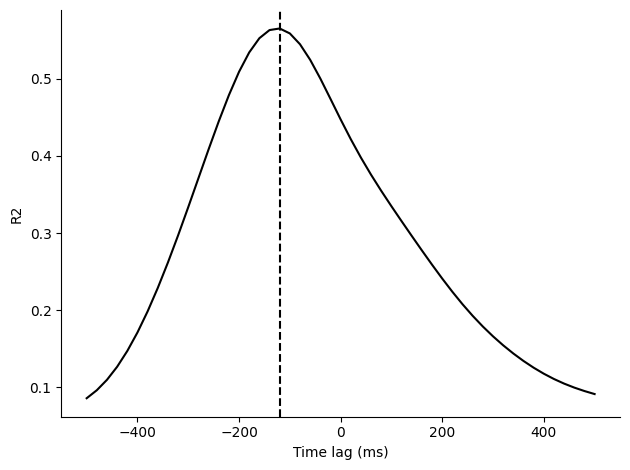

In [96]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, r2_array,color = 'k')
plt.axvline(lag_axis[np.argmax(r2_array)], color = 'k', linestyle='--')
print(r2_array)
print(lag_axis[np.argmax(r2_array)])
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
plt.show()

In [97]:
np.savez('RT_m1_single_lag', coef_array = coef_array, r2_array = r2_array, lag_axis = lag_axis) 

### Multi-lag

In [98]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_50_data_m1.pickle','rb') as f:
    m1_neural_data_50,m1_accs_50_binned,m1_vels_50_binned=pickle.load(f,encoding='latin1')
print(m1_neural_data_50.shape)
print(m1_accs_50_binned.shape)
print(m1_vels_50_binned.shape)

bin_width = 50

n_dims = 20
if not np.isnan(m1_neural_data_50).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(m1_neural_data_50)
    pca = PCA(n_components=n_dims,random_state = 42)
    neural_data_50_pca = pca.fit_transform(X)
    print(neural_data_50_pca.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
m1_neural_data_50_pca = neural_data_50_pca

(25299, 70)
(25299, 2)
(25299, 2)
(25299, 20)
PCA total var explained: 0.4517804347969658


Predicting with 0 to 0 ms neural data
(25299, 20)
0.3325659897141554
R2: 0.3335818587274444
Predicting with 0 to 50 ms neural data
(25299, 40)
0.38613894586974074
R2: 0.3873775150904095
Predicting with 0 to 100 ms neural data
(25299, 60)
0.41347046650887115
R2: 0.4147944610051324
Predicting with 0 to 150 ms neural data
(25299, 80)
0.42729292172424616
R2: 0.4286370297152462
Predicting with 0 to 200 ms neural data
(25299, 100)
0.43457268601768995
R2: 0.43594965505074845
Predicting with 0 to 250 ms neural data
(25299, 120)
0.43954337990143894
R2: 0.4409723196734793
Predicting with 0 to 300 ms neural data
(25299, 140)
0.4432494248475455
R2: 0.44473024212280055
Predicting with 0 to 350 ms neural data
(25299, 160)
0.44614471405619704
R2: 0.44766585566382633
Predicting with 0 to 400 ms neural data
(25299, 180)
0.44836954373984217
R2: 0.44991509732562274
Predicting with 0 to 450 ms neural data
(25299, 200)
0.4503634872193797
R2: 0.45196966057092824
Predicting with 0 to 500 ms neural data
(2529

/var/folders/c_/3p5f6szx247fkf6ftdgp147w0000gn/T/ipykernel_63652/3258213644.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


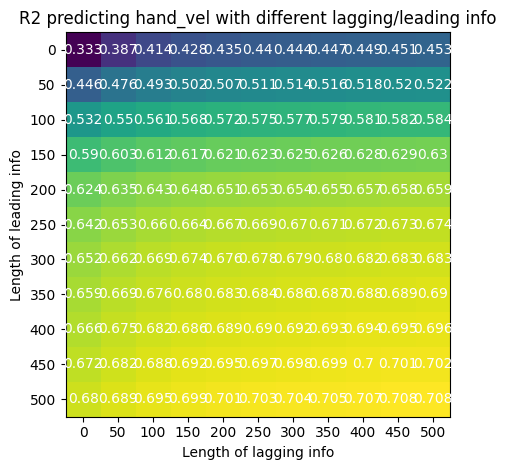

In [99]:
x_field = 'PCA'
y_field = 'hand_vel'

if x_field == 'neurons':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/neurons/M1/"
    x = m1_neural_data_50
if x_field == 'PCA':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/PCA/M1/"
    x = m1_neural_data_50_pca
if y_field == 'hand_vel':
    y = m1_vels_50_binned
if y_field == 'hand_acc':
    y = m1_accs_50_binned

t_before_range = range(0,501,50)
t_after_range = range(0,501,50)
m1_multi_R2s = nans([len(t_before_range),len(t_after_range)])
m1_multi_coefs = []
j,k = 0,0
for t_before in t_after_range:
    for t_after in t_after_range:
        print('Predicting with',-t_before, 'to', t_after,'ms neural data')
        bins_before= int(t_before/bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(t_after/bin_width) #How many bins of neural data after the output are used for decoding
        X_cov = get_spikes_with_history(x,bins_before,bins_after,bins_current)
        X_flat = X_cov.reshape(X_cov.shape[0],(X_cov.shape[1]*X_cov.shape[2]))
        print(X_flat.shape)
        X_chopped = X_flat[~np.isnan(X_flat).any(axis = 1)]
        y_chopped = y[0+bins_before:y.shape[0]-bins_after,:]
        r2, coef = multi_fit_r2_lasso(X_chopped,y_chopped)
        m1_multi_R2s[j,k] = r2
        m1_multi_coefs.append(coef)
        print('R2:',m1_multi_R2s[j,k])
        k+=1
    j+=1
    k=0

fig, ax = plt.subplots()
im = ax.imshow(m1_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title('R2 predicting ' + y_field +' with different lagging/leading info')
fig.tight_layout()
for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(m1_multi_R2s[i, j]*1000)/1000),
                        ha="center", va="center", color="w")

plt.tight_layout()
plt.show()
# plt.savefig(figDir + y_field + '_multi_lag.png', dpi = 'figure')
# plt.close()

Text(0.5, 0, 'Time lag (ms)')

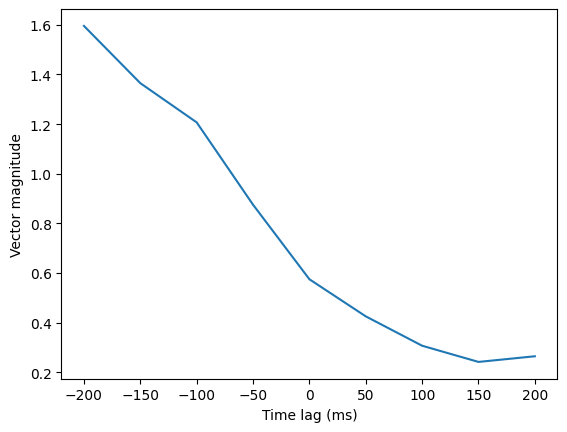

In [110]:
# 48 72 96 120
coef_X = m1_multi_coefs[48] #which entry's weights to use

t_label = np.arange(-200,201,50)
n_weights = len(t_label)
coef_X_reshaped = coef_X[1,:].reshape(n_weights,dim)
# angDist_array = nans([n_weights,n_weights])
# for i in range(n_weights):
#     for j in range(n_weights):
#         angDist_array[i,j] = math.degrees(angle_between(coef_X_reshaped[i,:],coef_X_reshaped[j,:]))
# fig, ax = plt.subplots(figsize=(6, 6))
# im = ax.imshow(angDist_array)
# ax.set_xlabel('Bin time (ms)')
# ax.set_ylabel('Bin time (ms)')

# ax.set_xticks(np.arange(len(t_label)))
# ax.set_yticks(np.arange(len(t_label)))
# ax.set_xticklabels(labels=t_label)
# ax.set_yticklabels(labels=t_label)

# ax.set_title("Angle between weight vectors at time points")
# fig.tight_layout()

# for i in range(len(t_label)):
#     for j in range(len(t_label)):
#         text = ax.text(j, i, str(int(angDist_array[i, j])),
#                         ha="center", va="center", color="w")
# plt.tight_layout()
# plt.show()
# # plt.savefig(figDir + y_field + '_multi_lag_angles.png', dpi = 'figure')
# # plt.close()

weights = [np.linalg.norm(i) for i in coef_X_reshaped]
plt.plot(range(-200,201,50),weights)
plt.ylabel('Vector magnitude')
plt.xlabel('Time lag (ms)')

In [102]:
import pickle
d = {'m1_multi_R2s': m1_multi_R2s, 'm1_multi_coefs': m1_multi_coefs}
pickle.dump(d, open('RT_m1_multi_lag_lasso.pickle', 'wb'))

d = pickle.load(open('RT_m1_multi_lag_lasso.pickle', 'rb'))

## PMd

### Load data

In [ ]:
# foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
# filename = foldername + "m1_data_raw.mat"
# pmd_data_raw = io.loadmat(filename)

# spike_times=pmd_data_raw['spike_times'][70:,:] #neurons after 70 are PMd neurons
# acc = pmd_data_raw['acc']
# vel = pmd_data_raw['vels']
# times = pmd_data_raw['vel_times']

# #original data has 0.001 s = 1 ms bins 
# dt = 0.01
# t_start = times[0]
# t_end = times[-1]

# spike_times = np.squeeze(spike_times)
# for i in range(spike_times.shape[0]):
#     spike_times[i]=np.squeeze(spike_times[i])

# neural_data=bin_spikes(spike_times,dt,t_start,t_end)
# gauss_width = 40 #in ms
# bin_width = dt*1000
# smth_40 = smooth_spk(neural_data, gauss_width, bin_width)
# smth_20 = smooth_spk(neural_data, 20, bin_width)

# accs_binned=bin_output(acc,times,dt,t_start,t_end)
# vels_binned=bin_output(vel,times,dt,t_start,t_end)

# with open(foldername+'proc_data_pmd.pickle','wb') as f:
#     pickle.dump([smth_40, smth_20,accs_binned,vels_binned],f)

In [ ]:
# foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
# filename = foldername + "m1_data_raw.mat"
# pmd_data_raw = io.loadmat(filename)

# spike_times=pmd_data_raw['spike_times'][70:,:]
# acc = pmd_data_raw['acc']
# vel = pmd_data_raw['vels']
# times = pmd_data_raw['vel_times']

# #original data has 0.001 s = 1 ms bins 
# dt = 0.05 #50ms bins
# t_start = times[0]
# t_end = times[-1]

# spike_times = np.squeeze(spike_times)
# for i in range(spike_times.shape[0]):
#     spike_times[i]=np.squeeze(spike_times[i])

# neural_data_50=bin_spikes(spike_times,dt,t_start,t_end)
# accs_50_binned=bin_output(acc,times,dt,t_start,t_end)
# vels_50_binned=bin_output(vel,times,dt,t_start,t_end)

# with open(foldername+'proc_50_data_pmd.pickle','wb') as f:
#     pickle.dump([neural_data_50,accs_50_binned,vels_50_binned],f)

### Single-lag

In [ ]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_data_pmd.pickle','rb') as f:
    pmd_smth_40,pmd_smth_20,pmd_accs_binned, pmd_vels_binned=pickle.load(f,encoding='latin1')
print(pmd_smth_40.shape)
print(pmd_smth_20.shape)
print(pmd_accs_binned.shape)
print(pmd_vels_binned.shape)

n_neurons = pmd_smth_20.shape[1]

n_dims = 20
if not np.isnan(pmd_smth_40).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(pmd_smth_40)
    pca = PCA(n_components=n_dims,random_state = 42)
    smth_40_pca = pca.fit_transform(X)
    print(smth_40_pca.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
pmd_40_pca = smth_40_pca

In [ ]:
x_field = 'PCA'
y_field = 'hand_vel'

if x_field == 'neurons':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/neurons/PMd/"
    x = pmd_smth_40
if x_field == 'PCA':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/PCA/PMd/"
    x = pmd_40_pca
if y_field == 'hand_vel':
    y = pmd_vels_binned
if y_field == 'hand_acc':
    y = pmd_accs_binned

lag_axis = np.arange(-300,300,20)
pool = mp.Pool(mp.cpu_count())
pmd_r2_array = [pool.starmap(mp_fit_lag_r2, [(x,y,lag,10) for lag in lag_axis])][0]
pool.close()

idx_max = np.argmax(pmd_r2_array)
time_max = lag_axis[idx_max]
plt.plot(lag_axis, pmd_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score predicting ' + y_field )
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig(figDir + y_field +'_0.png', dpi = 'figure')
plt.close()

_, weights, _ = fit_and_predict(x,y,time_max,bin_size=10)
#subtract predictions with primary decoding dimensions (at time with max R2)
pool = mp.Pool(mp.cpu_count())
pmd_sub_r2_array = [pool.starmap(mp_sub_lag_r2, [(x,y,lag,10,weights) for lag in lag_axis])][0]
pool.close()
plt.plot(lag_axis,pmd_sub_r2_array)
plt.title('R2 score projecting out #1 t_max dim')
idx_max = np.argmax(pmd_sub_r2_array)
time_max = lag_axis[idx_max]
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig(figDir + y_field +'_1.png', dpi = 'figure')
plt.close()


### Multi-lag

In [ ]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_50_data_pmd.pickle','rb') as f:
    pmd_neural_data_50,pmd_accs_50_binned,pmd_vels_50_binned=pickle.load(f,encoding='latin1')
print(pmd_neural_data_50.shape)
print(pmd_accs_50_binned.shape)
print(pmd_vels_50_binned.shape)

bin_width = 50

n_dims = 20
if not np.isnan(pmd_neural_data_50).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(pmd_neural_data_50)
    pca = PCA(n_components=n_dims,random_state = 42)
    neural_data_50_pca = pca.fit_transform(X)
    print(neural_data_50_pca.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
pmd_neural_data_50_pca = neural_data_50_pca

In [ ]:
x_field = 'PCA'
y_field = 'hand_acc'

if x_field == 'neurons':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/neurons/PMd/"
    x = pmd_neural_data_50
if x_field == 'PCA':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/PCA/PMd/"
    x = pmd_neural_data_50_pca
if y_field == 'hand_vel':
    y = pmd_vels_50_binned
if y_field == 'hand_acc':
    y = pmd_accs_50_binned

t_before_range = range(0,301,50)
t_after_range = range(0,301,50)
pmd_multi_R2s = nans([len(t_before_range),len(t_after_range)])
j,k = 0,0
for t_before in t_after_range:
    for t_after in t_after_range:
        print('Predicting with',-t_before, 'to', t_after,'ms neural data')
        bins_before= int(t_before/bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(t_after/bin_width) #How many bins of neural data after the output are used for decoding
        X_cov = get_spikes_with_history(x,bins_before,bins_after,bins_current)
        X_flat = X_cov.reshape(X_cov.shape[0],(X_cov.shape[1]*X_cov.shape[2]))
        print(X_flat.shape)
        X_chopped = X_flat[~np.isnan(X_flat).any(axis = 1)]
        y_chopped = y[0+bins_before:y.shape[0]-bins_after,:]
        pmd_multi_R2s[j,k] = multi_fit_r2(X_chopped,y_chopped)
        print('R2:',pmd_multi_R2s[j,k])
        k+=1
    j+=1
    k=0

fig, ax = plt.subplots()
im = ax.imshow(pmd_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title('R2 predicting ' + y_field +' with different lagging/leading info')
fig.tight_layout()
for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(pmd_multi_R2s[i, j]*1000)/1000),
                        ha="center", va="center", color="w")

plt.tight_layout()
plt.savefig(figDir + y_field + '_multi_lag.png', dpi = 'figure')
plt.close()